In [2]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.io import fits
from astropy.table import Table
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord, Galactocentric, ICRS
from astropy.constants import kpc, au
from astropy.coordinates import CartesianRepresentation, CartesianDifferential
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product, matrix_transpose
from numba import njit

from implied_d_vr import implied_calculations
from selections import is_HVS

import healpy as hp

# Testing my implementation of Sills selections

If I apply the selections to the 600 HVS candidates, all of them should pass

In [3]:
# Test with Sill's already computed stars
# Load the data
sills_candidates = pd.read_csv("/Users/mncavieres/Documents/2024-2/HVS/Data/Sill Candidates/full_candidate_list.txt")

# Query Gaia DR3 for the parallax and proper motions
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
from astropy import units as u

source_ids_sills_candidates = sills_candidates["GaiaDR3_source_id"].values
source_ids_str = ','.join(str(id) for id in source_ids_sills_candidates)


# Connect to Gaia
job = Gaia.launch_job_async(f"SELECT * \
                             FROM gaiaedr3.gaia_source \
                            JOIN external.gaiaedr3_distance USING (source_id) \
                             WHERE source_id IN ({source_ids_str}) \
                            ")

# Get the results
gaia_results = job.get_results()
#gaia_results = gaia_results.to_pandas()


INFO: Query finished. [astroquery.utils.tap.core]


In [4]:
data = implied_calculations(gaia_results)

Computing R0 and V0...
Computing distances and velocities...
Distances and velocities computed successfully!


In [5]:
data

solution_id,designation,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,flag,source_id,implied_parallax,implied_parallax_error,VGCR,VR
,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,deg,deg,deg,deg,pc,pc,pc,pc,pc,pc,,,1 / pc,1 / pc,,
int64,object,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,object,int64,float64,float64,float64,float64
1636042515805110273,Gaia EDR3 3367563599569024,627526622,2016.0,49.07700564449039,0.35985,5.748888069129046,0.37053367,0.32218677049802524,0.45902526,0.7018933,3.6308248,3.628164015440435,0.48468414,-0.13897729227328248,0.42572019,0.218995,0.0074679204,0.062246747,-0.12862405,-0.48204195,-0.12952839,-0.116383426,-0.014902249,0.17474893,0.19979985,191,0,187,4,3.8294702,275.31723,1.5297276,3.1463661,95,False,--,1.4119714,0.111067384,-0.2147179,-0.010446816,-0.07597882,0.1365481,-0.059920307,22,14,0.7050496,22,8,0,0.037126087,102.58662,0,0,1.2059196,0.32398942,0.22979695,0.519942,0.8287964,-103.31896,-26.994312,-44.83262,29.547693,False,181,277.2104094293237,1.0885421,254.6621,19.580343,7,156.6090536287528,14.824695,10.564066,19.8515,9,160.3623975520148,21.23003,7.5535645,19.23514,0,0,0,0,0,1.1434327,0.6163597,0.2711563,0.3452034,--,--,0,--,--,--,175.18245387039892,-41.96

In [6]:
#data.to_pandas().to_csv("/Users/mncavieres/Documents/2024-2/HVS/Data/Sill Candidates/sills_candidates.csv", index=False)

In [7]:
from astropy.table import Table, vstack

# What is going on with HEALPix pixels

All of the candidates should be within the NSIDE = 3, RING scheme  HEALPix pixels given by the following list

In [8]:
# Expand the specified pixel ranges into a list
pixels = np.concatenate([
    np.arange(0, 20),          # 0–19
    np.arange(22, 32),         # 22–31
    np.arange(35, 43),         # 35–42
    np.arange(46, 56),         # 46–55
    np.arange(58, 63),         # 58–62
    [65, 66],
    np.arange(69, 74),         # 69–73
    [78],
    np.arange(82, 86),         # 82–85
    np.arange(93, 97),         # 93–96
    [101, 102, 103],
    [107]
    ])

In [9]:
# compute the NSIDE 3 ring scheme HEALPix pixel for each source
nside = 3
# Compute the HEALPix pixel number for each coordinate (ring ordering)
pix_nums = hp.ang2pix(nside, data['l'], data['b'], nest=False, lonlat=True)

# Compute with RA and DEC
theta = np.radians(90 - data['dec'])  # Colatitude in radians
phi = np.radians(-data['ra'])  # Longitude in radians

# Compute the HEALPix pixel number for each coordinate (ring ordering)
pix_nums = hp.ang2pix(nside, theta, phi, nest=False)
#pix_nums = hp.ang2pix(nside,np.pi*(90-dec_deg)/180,np.pi*ra_deg/180)

In [10]:
bool_check_pix = np.isin(pix_nums, pixels)

In [11]:
for boolean in bool_check_pix:
    if not boolean:
        print("There are stars outside the pixel range")


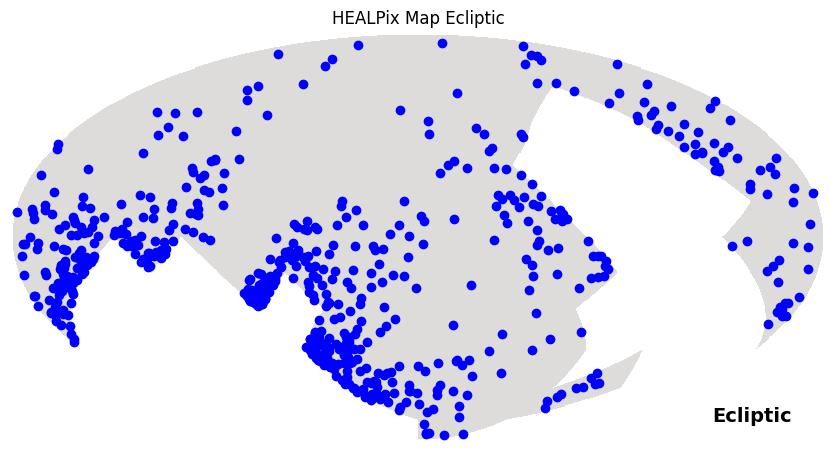

In [12]:
# Call the function to plot
#plot_healpix_with_marked_pixels(pixels, nside=3)
# also plot failed stars
# Create a blank map with zeros
nside = 3
npix = hp.nside2npix(nside)
healpix_map = np.full(npix, hp.UNSEEN)  # Fill with UNSEEN values

# Mark the specified pixels with a value (e.g., 1)
healpix_map[pixels] = 1



# Plot the map using mollweide projection and show the graticule
#hp.mollview(healpix_map, title="HEALPix Graticule with Marked Pixels", cmap='coolwarm', badcolor='white',
#            norm=None, cbar=False, coord='E', nest = False)
# Plot the HEALPix map using mollweide projection centered on the Galactic plane
hp.mollview(healpix_map, title="HEALPix Map Ecliptic", cmap='coolwarm', badcolor='white',
            norm=None, cbar=False, coord='E', rot=(0, 0), nest=False)

theta = np.radians(90 - data['dec'])  # Colatitude in radians
phi = np.radians(-data['ra'])  # Longitude in radians
hp.projscatter(theta, phi, marker='o', color='blue', lonlat=False)    
#hp.projscatter(data['l'], data['b'], marker='o', color='blue', lonlat = True)
# Display the plot
plt.show()



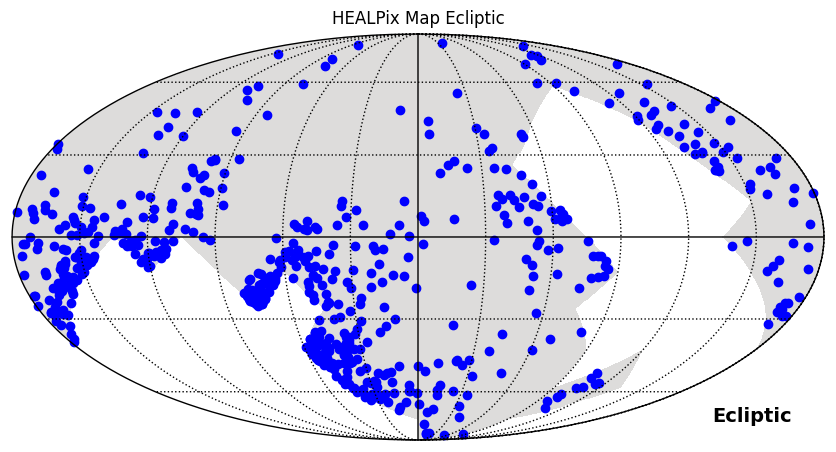

In [14]:
# Call the function to plot
#plot_healpix_with_marked_pixels(pixels, nside=3)
# also plot failed stars
# Create a blank map with zeros
nside = 3
npix = hp.nside2npix(nside)
healpix_map = np.full(npix, hp.UNSEEN)  # Fill with UNSEEN values

# Mark the specified pixels with a value (e.g., 1)
healpix_map[pixels] = 1



# Plot the map using mollweide projection and show the graticule
#hp.mollview(healpix_map, title="HEALPix Graticule with Marked Pixels", cmap='coolwarm', badcolor='white',
#            norm=None, cbar=False, coord='E', nest = False)
# Plot the HEALPix map using mollweide projection centered on the Galactic plane
hp.mollview(healpix_map, title="HEALPix Map Ecliptic", cmap='coolwarm', badcolor='white',
            norm=None, cbar=False, coord='E', rot=(0, 0), nest=False)

theta = np.radians(90 - data['dec'])  # Colatitude in radians
phi = np.radians(-data['ra'])  # Longitude in radians
hp.projscatter(theta, phi, marker='o', color='blue', lonlat=False)    
#add grid
hp.graticule()
#hp.projscatter(data['l'], data['b'], marker='o', color='blue', lonlat = True)
# Display the plot
plt.show()



In [44]:
min(data['l']), max(data['l']), min(data['b']), max(data['b'])

(np.float64(0.13001169766083248),
 np.float64(359.96147699313155),
 np.float64(-83.63003032364453),
 np.float64(80.96007358012568))

# Check if I downloaded all of Gaia

In [76]:
nside = 16
npix = hp.nside2npix(nside)
print(npix)

3072


In [75]:
# compute how much memory will the data take given that it is 33 columns of 64-bit floats
print(f"Memory usage: {33 * 1.8e9 * 8 / 1024**3:.2f} GB")

Memory usage: 442.56 GB


In [15]:
pixels_queried = np.arange(0, 192)

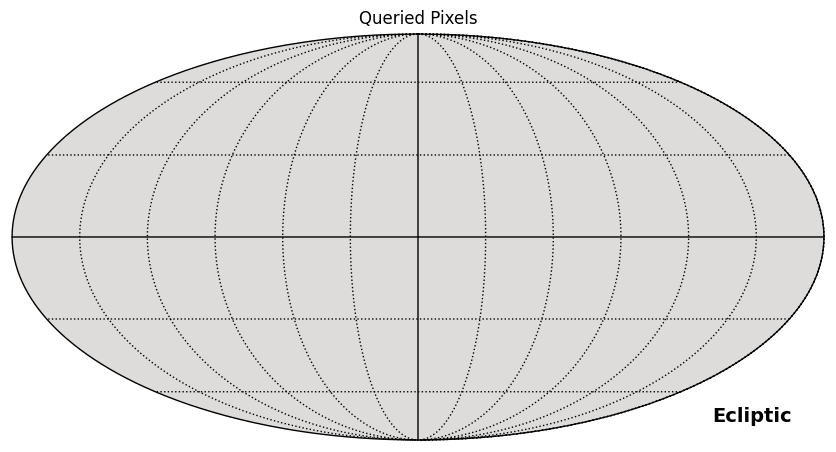

In [18]:
# Call the function to plot
#plot_healpix_with_marked_pixels(pixels, nside=3)
# also plot failed stars
# Create a blank map with zeros
nside = 4
npix = hp.nside2npix(nside)
healpix_map = np.full(npix, hp.UNSEEN)  # Fill with UNSEEN values

# Mark the specified pixels with a value (e.g., 1)
healpix_map[pixels_queried] = 1



# Plot the map using mollweide projection and show the graticule
#hp.mollview(healpix_map, title="HEALPix Graticule with Marked Pixels", cmap='coolwarm', badcolor='white',
#            norm=None, cbar=False, coord='E', nest = False)
# Plot the HEALPix map using mollweide projection centered on the Galactic plane
hp.mollview(healpix_map, title="Queried Pixels", cmap='coolwarm', badcolor='white',
            norm=None, cbar=False, coord='E', rot=(0, 0), nest=False)

theta = np.radians(90 - data['dec'])  # Colatitude in radians
phi = np.radians(-data['ra'])  # Longitude in radians
#hp.projscatter(theta, phi, marker='o', color='blue', lonlat=False)    
#add grid
hp.graticule()
#hp.projscatter(data['l'], data['b'], marker='o', color='blue', lonlat = True)
# Display the plot
plt.show()



# Check if the stars are on my downloads

In [28]:
from tqdm import tqdm
from selections import is_HVS
from implied_d_vr import implied_calculations
from download_gaia_by_healpix import query
import seaborn as sns

In [40]:
output_path = "/Users/mncavieres/Documents/2024-2/HVS/Data/replicated_candidates_by_healpix"
gaia_catalogs_path = "/Users/mncavieres/Documents/2024-2/HVS/Data/Gaia_tests/gaia_by_healpix"

In [41]:
# read gaia database credentials from file
with open("/Users/mncavieres/Documents/2024-2/HVS/gaia_credentials.txt", "r") as f:
    username = f.readline().strip()
    password = f.readline().strip()

In [42]:
# Assuming 'data' is your astropy table with 'source_id' column
data['is_in_gaia'] = np.zeros(len(data), dtype=bool)

In [43]:
# Parameters
nside = 4  # HEALPix nside
npix = hp.nside2npix(nside)  # Total number of pixels for the given nside

# Initialize a map to store the density of sources per HEALPix pixel
healpix_map = np.zeros(npix)

In [ ]:
# check if the stars are in the data files

for healpix_pixel in tqdm(np.arange(0, 192)):
    print(f"Processing HEALPix pixel {healpix_pixel}")

    # Check if the data is already downloaded
    if os.path.exists(os.path.join(gaia_catalogs_path, f"healpix_{healpix_pixel}.fits")):
        print(f"File exists, loading from file")
        data_gaia = Table.read(os.path.join(gaia_catalogs_path, f"healpix_{healpix_pixel}.fits"))
    else:
        # Query Gaia EDR3 for sources within the specified HEALPix pixel
        data_gaia = query(healpix_pixel, nside=nside, login= True, username= username, password = password)

    # Check if the source_ids from the data are in the current Gaia file
    mask = np.isin(data['source_id'], data_gaia['source_id'])
    
    # Count the number of sources in this HEALPix pixel and add to the map
    healpix_map[healpix_pixel] += len(data_gaia)

    # If a star is found in the Gaia data, set 'is_in_gaia' to True
    data['is_in_gaia'][mask] = True

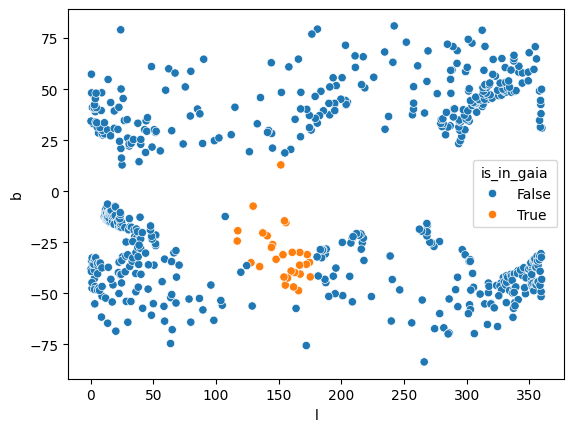

In [63]:
sns.scatterplot(data = data.to_pandas(), x = 'l', y = 'b' , hue=data['is_in_gaia'])
plt.show()

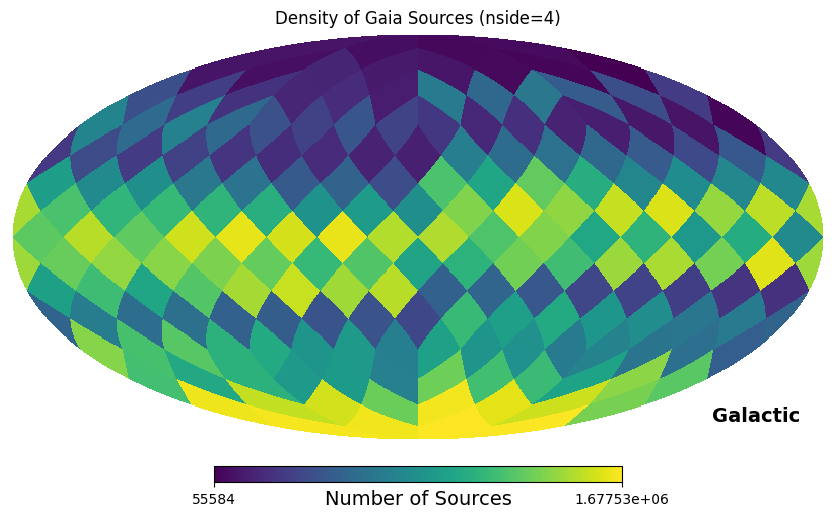

In [64]:
# Plotting the density map using healpy
hp.mollview(healpix_map, title="Density of Gaia Sources (nside=4)", unit="Number of Sources", norm="hist", cmap="viridis", cbar=True, coord='G')
plt.show()

In [67]:
np.sum(healpix_map) - 1811709771

np.float64(-1737807577.0)

In [57]:
1467744818 - 1811709771

-343964953

In [ ]:
# why are they not in the gaia data?
# Check the stars that are not in the Gaia data
data

In [95]:
HEALPix_pixel = 4

In [96]:
# Calculate source ID range for the HEALPix pixel at the given nside
factor = (2**35) * (4**(12 - 4))  # Scaling factor based on level
source_id_min = HEALPix_pixel * factor
source_id_max = (HEALPix_pixel + 1) * factor

In [97]:
int(source_id_max)

11258999068426240

In [93]:
2**4

16

In [94]:
hp.nside2npix(16)

3072